In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [17]:
mu = 1
sigma = 2
learning_rate = 1e-1
epsilon = 1.5
num_epochs = 3
TEST_SIZE = 100
TRAIN_SIZE = 30
BEST_MODEL_PATH = 'best_gaussian_mixture_linear_loss_model.pt'

In [18]:
class WeightClipper(object):
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            W = 2.
            module.weight.data = w.clamp(-W, W)

clipper = WeightClipper()

In [19]:
x_test = torch.unsqueeze(torch.cat([torch.distributions.Normal(-mu, sigma).sample((TEST_SIZE,)), torch.distributions.Normal(mu, sigma).sample((TEST_SIZE,))]), dim=1).float()
y_test = torch.unsqueeze(torch.cat([-torch.ones(TEST_SIZE), torch.ones(TEST_SIZE)]), dim=1).float()
test_set = Data.TensorDataset(x_test, y_test)
test_loader = Data.DataLoader(dataset=test_set, batch_size=TEST_SIZE//10, shuffle=False)

In [20]:
def linear_loss(output, target):
    return -output.t() @ target

In [21]:
def fgsm(model, x, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    x.requires_grad = True
    output = model(x)
    loss = loss_fn(output, y)
    model.zero_grad()
    loss.backward()
    return epsilon * x.grad.data.sign()

In [22]:
def fit(num_epochs, train_loader, model, loss_fn, opt):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0
        best_loss = float('inf')
        
        for x, y in train_loader:
            opt.zero_grad()
            delta = fgsm(model, x, y, epsilon)
            # perturbed training data
            x_pert = x + delta
            # predicted output
            y_pred = model(x_pert)
            loss = loss_fn(y_pred, y)
            loss.backward()
            opt.step()
            model.apply(clipper)
            sum_loss += float(loss)
        epoch_train_loss = sum_loss / train_size
        if epoch_train_loss < best_loss:
            best_loss = epoch_train_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

    sum_test_loss = 0
    model = nn.Linear(1, 1, bias=False)
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    for x, y in test_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        sum_test_loss += loss
    temp = sum_test_loss / TEST_SIZE
    return temp

In [23]:
loss_fn = linear_loss
test_losses = np.zeros(TRAIN_SIZE)

for train_size in range(1, TRAIN_SIZE+1):
    N = 30
    temp = np.zeros(N)
    for i in range(N):
        model = nn.Linear(1, 1, bias=False)
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        batch_size = min(5, train_size)
        x_train = torch.unsqueeze(torch.cat([torch.distributions.Normal(-mu, sigma).sample((train_size,)), torch.distributions.Normal(mu, sigma).sample((train_size,))]), dim=1).float()
        y_train = torch.unsqueeze(torch.cat([-torch.ones(train_size), torch.ones(train_size)]), dim=1).float()
        train_set = Data.TensorDataset(x_train, y_train)
        train_loader = Data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        test_loss = fit(num_epochs, train_loader, model, loss_fn, opt)
        temp[i] = test_loss.item()
    mean = np.mean(temp)
    test_losses[train_size-1] = test_loss.item()

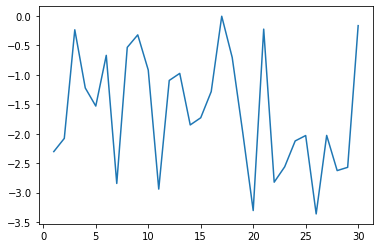

In [24]:
train_sizes = np.arange(1, TRAIN_SIZE+1)
plt.plot(train_sizes, test_losses)

In [25]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.0824]], requires_grad=True)]


In [26]:
test_losses

array([-2.30410981e+00, -2.07975698e+00, -2.32964337e-01, -1.22222710e+00,
       -1.52994478e+00, -6.67629838e-01, -2.84599113e+00, -5.31799257e-01,
       -3.19110572e-01, -9.17389452e-01, -2.94190884e+00, -1.09418046e+00,
       -9.74221587e-01, -1.85078371e+00, -1.72890401e+00, -1.28361845e+00,
       -2.54786247e-03, -7.04100192e-01, -1.97465825e+00, -3.30652475e+00,
       -2.21575886e-01, -2.82427025e+00, -2.56279755e+00, -2.12306833e+00,
       -2.03107309e+00, -3.36403656e+00, -2.02904987e+00, -2.62721705e+00,
       -2.57184172e+00, -1.62405401e-01])